# Fuzzy clustering

So, “fuzzy” here means “not sure”, which indicates that it’s a soft clustering method. “C-means” means c cluster centers, which only replaces the “K” in “K-means” with a “C” to make it look different.

In a clustering algorithm, if the probability of one data point belonging to a cluster can only take the value of 1 or 0, it’s hard clustering. The boundary of a cluster in a hard clustering method can be visualized as a crisp boundary. On the contrary, in a soft clustering method, the probability of one data point belonging to a cluster can take any value between 0 and 1, such as 75%, for which the boundary of a cluster can be visualized as a fuzzy boundary.

``` hard and soft clustering```
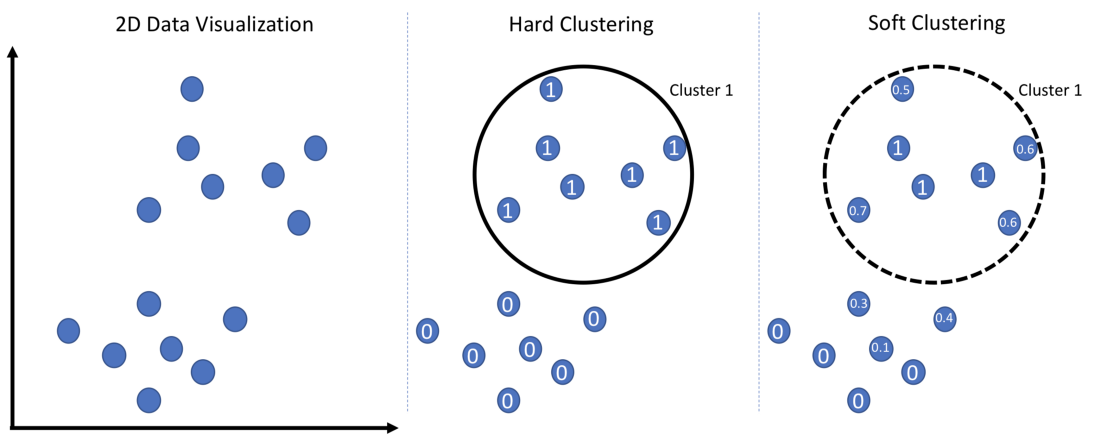

## Fuzzy C-mean clustering (FCM) ,Fuzzy gustafson-kessel (GK)


In [1]:
from sklearn.datasets import load_iris
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from sklearn.datasets import load_wine


The main difference between FCM and GK is the way of calculating the distance.
in FCM we use the `euclidean` distance,in GK we use the `mahalanobies` distance.

``` Understand the Parameters ```

In the Fuzzy c-means (FCM) clustering method, we have two parameters, μ_ij and c_i, and one hyperparameter, m.

μ_ij, membership value, is the probability that the jth data point belongs to the ith cluster, and it is constrained to that the sum of μ_ij over C cluster centers is 1 for every data point j. c_i is the center of the ith cluster (the same dimension with X). And m is the fuzzifier, which controls how fuzzy the cluster boundary should be.

In [2]:
"""
Implementing the algrithm on the iris data set

d refers to the size of the data
k refers to the number of clusters
p is constant used in the equation

"""
iris = load_iris()
wine = load_wine()
X = iris.data[:, 0:] # petal length and width
d = len(X) 
k = 3
p = 2
error = 1e-5
max_iter = 150

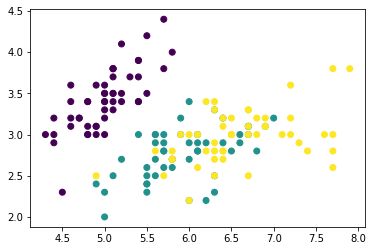

In [3]:
import matplotlib.pyplot as plt
plt.scatter(iris.data[:,0],iris.data[:,1],c=iris.target)

Initializing μ_ij,u randomly 

In [4]:
#initialize memberships
rnd = np.random.RandomState(42)
memberships = rnd.rand(d,k)

#update membership relative to classes
summation = memberships.sum(axis=1).reshape(-1,1)
denominator = np.repeat(summation,k,axis=1)
memberships = memberships/denominator
memberships

array([[0.18205878, 0.46212909, 0.35581214],
       [0.65738127, 0.17132261, 0.17129612],
       [0.03807826, 0.56784481, 0.39407693],
       [0.41686469, 0.01211874, 0.57101657],
       [0.67865488, 0.173111  , 0.14823412],
       [0.18115758, 0.3005149 , 0.51832752],
       [0.32354776, 0.21814475, 0.45830749],
       [0.17480426, 0.36609589, 0.45909985],
       [0.31651311, 0.54491305, 0.13857384],
       [0.44595846, 0.51375845, 0.04028309],
       [0.72059071, 0.20225354, 0.07715574],
       [0.34848152, 0.35463173, 0.29688675],
       [0.28035754, 0.08989454, 0.62974792],
       [0.41627195, 0.11541703, 0.46831101],
       [0.02859779, 0.75619858, 0.21520363],
       [0.4433659 , 0.20859987, 0.34803422],
       [0.321377  , 0.10866445, 0.56995855],
       [0.29704731, 0.36003589, 0.34291679],
       [0.37176668, 0.5732098 , 0.05502352],
       [0.34592914, 0.07983064, 0.57424022],
       [0.26107384, 0.18226466, 0.5566615 ],
       [0.30223499, 0.23800266, 0.45976235],
       [0.

`mahalanobies` distance formula is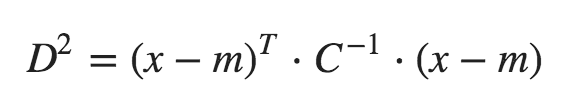
and `C` in the law refers to covariance,Its formula is 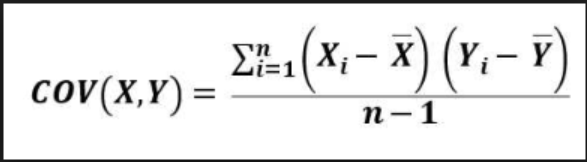 

In [5]:
def _calculate_fuzzyCov(X,memberships,new_class_centers):
        #calculating covariance matrix in its fuzzy form  
        fuzzyMem = memberships ** p
        n_clusters = k
        FcovInv_Class = []
        dim = X.shape[1]
        for i in range(n_clusters): 
            diff = X-new_class_centers[i]
            left = np.dot((fuzzyMem[:,i].reshape(-1,1)*diff).T,diff)/np.sum(fuzzyMem[:,i],axis=0)
            Fcov = (np.linalg.det(left)**(-1/dim))*left
            FcovInv = np.linalg.inv(Fcov)
            FcovInv_Class.append(FcovInv)
        return FcovInv_Class

def _calculate_dist(X,memberships,new_class_centers,method):
    if method == 'Gustafson–Kessel':
        n_clusters = k
        FcovInv_Class = _calculate_fuzzyCov(X,memberships,new_class_centers)
        #calculating mahalanobis distance
        mahalanobis_Class = []
        for i in range(n_clusters): 
            diff = X-new_class_centers[i]
            left = np.dot(diff,FcovInv_Class[i])    
            mahalanobis = np.diag(np.dot(left,diff.T))
            mahalanobis_Class.append(mahalanobis)
        distance = np.array(mahalanobis_Class).T
    else:
        distance = cdist(X, new_class_centers,metric='euclidean')
    return distance

update c_i and u_ij,if the change is very low stop
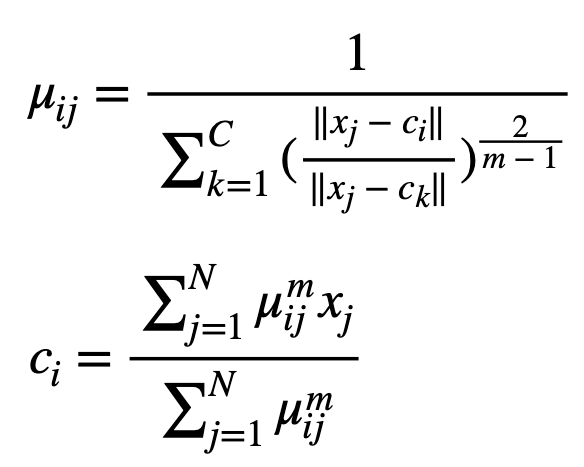

In [6]:
iterations = 0
gk = "Gustafson–Kessel"
cmean = "euclidean"
while iterations < max_iter:
    copy_of_mem = memberships.copy()
    fuzzyMem = memberships ** p
    new_class_centers = (np.dot(X.T,fuzzyMem)/np.sum(fuzzyMem,axis=0)).T

    distance = _calculate_dist(X,memberships, new_class_centers,gk)
    power = float(2/(p - 1))
    distance = distance**(power)
    arr = np.zeros((d,k))
    for i in range(k):
        for ii in range(k):
            arr[:,ii] = ((distance[:,i]/distance[:,ii]))
        memberships[:,i] = 1/np.sum(arr,axis=1)
    iterations=iterations+1
    if norm(memberships - copy_of_mem) < error:
        break
memberships

array([[8.61935890e-07, 3.46456071e-06, 9.99995674e-01],
       [2.97749232e-05, 1.72069327e-04, 9.99798156e-01],
       [9.89349730e-06, 4.67019415e-05, 9.99943405e-01],
       [2.23582909e-05, 1.02317396e-04, 9.99875324e-01],
       [2.40769908e-06, 8.78196224e-06, 9.99988810e-01],
       [5.52617352e-05, 2.06429911e-04, 9.99738308e-01],
       [7.30644298e-05, 3.07887534e-04, 9.99619048e-01],
       [6.02267690e-07, 2.43830786e-06, 9.99996959e-01],
       [8.18252108e-05, 4.47167764e-04, 9.99471007e-01],
       [6.26159367e-05, 2.68682610e-04, 9.99668701e-01],
       [1.24666649e-05, 4.57232772e-05, 9.99941810e-01],
       [2.40213699e-05, 8.70618054e-05, 9.99888917e-01],
       [5.59343618e-05, 2.66697032e-04, 9.99677369e-01],
       [3.18201998e-04, 1.48378671e-03, 9.98198011e-01],
       [2.13913224e-04, 7.82209966e-04, 9.99003877e-01],
       [1.28109876e-04, 4.09904650e-04, 9.99461985e-01],
       [1.04022644e-04, 4.25099165e-04, 9.99470878e-01],
       [1.92565400e-06, 8.68206

## plotting the results

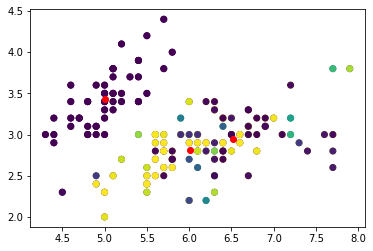

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
plt.scatter(X[:,0], X[:,1], c=memberships[:,0])
plt.scatter(X[:,0], X[:,1], c=memberships[:,1])
plt.scatter(new_class_centers[:,0], new_class_centers[:,1],marker='o',color='r')

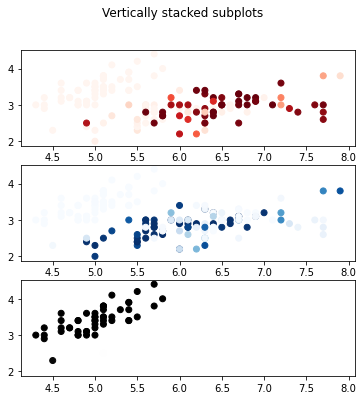

In [11]:
fig, axs = plt.subplots(3,figsize=(6,6))
fig.suptitle('Vertically stacked subplots')
axs[0].scatter(X[:,0], X[:,1], c=memberships[:,0],cmap="Reds")
axs[1].scatter(X[:,0], X[:,1], c=memberships[:,1],cmap="Blues")
axs[2].scatter(X[:,0], X[:,1], c=memberships[:,2],cmap="Greys")
